In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing


#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn.preprocessing import StandardScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor



#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

### Read Data from CSV

In [29]:
data = pd.read_csv('Arms-import.csv')

In [30]:
data.head()

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2017,250000000.0,NaN
1,Afghanistan,2016,176000000.0,NaN
2,Afghanistan,2015,116000000.0,NaN
3,Afghanistan,2014,288000000.0,NaN
4,Afghanistan,2013,235000000.0,NaN


#### lets drop extra column Value Footnotes

In [31]:
# Read data from csv and print the head
data = data.drop(columns=['Value Footnotes'])
data.head(5)

,Country or Area,Year,Value
0,Afghanistan,2017,250000000.0
1,Afghanistan,2016,176000000.0
2,Afghanistan,2015,116000000.0
3,Afghanistan,2014,288000000.0
4,Afghanistan,2013,235000000.0


#### Get data insights

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8258 entries, 0 to 8257
Data columns (total 3 columns):
Country or Area    8258 non-null object
Year               8258 non-null object
Value              8256 non-null float64
dtypes: float64(1), object(2)
memory usage: 193.6+ KB


#### it seems column Value has some missing values or NaN 

In [33]:
vals = data['Value']

In [34]:
d = data[ vals.isna() ]
d

,Country or Area,Year,Value
8256,footnoteSeqID,Footnote,NaN
8257,2,Value of deliveries is less than 0.5 million TIV,NaN


##### lets drop this entries

In [35]:
data  = data [0:8256] 

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8256 entries, 0 to 8255
Data columns (total 3 columns):
Country or Area    8256 non-null object
Year               8256 non-null object
Value              8256 non-null float64
dtypes: float64(1), object(2)
memory usage: 193.6+ KB


In [37]:
data['Country or Area'].nunique()

232

### Lets normalize data

In [38]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [39]:
# Check new dataframe with normalized value
data_new.head()

,Country or Area,Year,normalized
0,Afghanistan,2017,0.005994
1,Afghanistan,2016,0.004220
2,Afghanistan,2015,0.002781
3,Afghanistan,2014,0.006905
4,Afghanistan,2013,0.005634


#### Using tsfresh to extract features from data

In [40]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [00:23<00:00,  2.11s/it]


In [41]:
#Check extracted features
extracted_features.head()

variable,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,normalized__time_reversal_asymmetry_statistic__lag_1,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.008196,0.177612,-0.034824,-0.060815,0.048577,0.016054,0.075831,0.000937,0.007117,NaN,...,1.541280e-07,5.190910e-07,1.163574e-06,0.0,0.0,0.0,0.0,0.0,0.000121,0.0
Albania,0.000262,0.028004,-0.060133,-0.056351,0.147890,0.008511,-0.814430,-0.003381,0.002409,NaN,...,1.656633e-10,6.605287e-11,-1.028939e-09,0.0,1.0,0.0,0.0,0.0,0.000006,0.0
Algeria,0.019031,0.391522,0.055072,0.044231,0.068417,0.018656,0.688800,0.007167,0.003772,0.045506,...,1.900281e-06,9.291907e-07,1.466092e-07,0.0,0.0,0.0,0.0,0.0,0.000179,0.0
Angola,0.002455,0.097557,-0.040989,-0.061263,0.067736,0.020283,-0.547124,-0.004388,0.004746,NaN,...,5.265793e-08,1.583488e-07,1.709011e-07,0.0,0.0,0.0,0.0,0.0,0.000039,0.0
Arab World,1.755274,1.643099,0.013193,0.039605,0.301875,0.209934,0.105092,0.006611,0.031280,0.393177,...,5.952909e-04,7.425558e-04,7.641989e-04,0.0,0.0,0.0,0.0,0.0,0.007977,0.0


In [42]:
#Check shape of new data with extracted features
extracted_features.shape

(232, 794)

In [43]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

548

In [44]:
# it seems 548 columns out of 794 have some null values

In [45]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

 'normalized__fft_coefficient__coeff_30__attr_"angle"'
 'normalized__fft_coefficient__coeff_30__attr_"imag"'
 'normalized__fft_coefficient__coeff_30__attr_"real"'
 'normalized__fft_coefficient__coeff_31__attr_"abs"'
 'normalized__fft_coefficient__coeff_31__attr_"angle"'
 'normalized__fft_coefficient__coeff_31__attr_"imag"'
 'normalized__fft_coefficient__coeff_31__attr_"real"'
 'normalized__fft_coefficient__coeff_32__attr_"abs"'
 'normalized__fft_coefficient__coeff_32__attr_"angle"'
 'normalized__fft_coefficient__coeff_32__attr_"imag"'
 'normalized__fft_coefficient__coeff_32__attr_"real"'
 'normalized__fft_coefficient__coeff_33__attr_"abs"'
 'normalized__fft_coefficient__coeff_33__attr_"angle"'
 'normalized__fft_coefficient__coeff_33__attr_"imag"'
 'normalized__fft_coefficient__coeff_33__attr_"real"'
 'normalized__fft_coefficient__coeff_34__attr_"abs"'
 'normalized__fft_coefficient__coeff_34__attr_"angle"'
 'normalized__fft_coefficient__coeff_34__attr_"imag"'
 'normalized__fft_coefficie

In [46]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [47]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [48]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 0
        data_after_impute.at[i,'label'] = val
    elif da['id'] not in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val

In [49]:
# check new df with added column as label 
data_after_impute.head(2)

variable,id,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation,label
0,Afghanistan,0.008196,0.177612,-0.034824,-0.060815,0.048577,0.016054,0.075831,0.000937,0.007117,...,5.190910e-07,1.163574e-06,0.0,0.0,0.0,0.0,0.0,0.000121,0.0,1
1,Albania,0.000262,0.028004,-0.060133,-0.056351,0.147890,0.008511,-0.814430,-0.003381,0.002409,...,6.605287e-11,-1.028939e-09,0.0,1.0,0.0,0.0,0.0,0.000006,0.0,1


In [50]:
#data_after_impute.to_csv('Arms-extracted-feature.csv')
data_after_impute.shape

(232, 796)

In [51]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

In [52]:
y.value_counts()

1    197
0     35
Name: label, dtype: int64

In [53]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [55]:
y_test.value_counts()

1    77
0    16
Name: label, dtype: int64

#### Lets try different classifiers on the data

##### KNN

###### KNN with k ranging from 1 to 15

[0.7613671889564816, 0.7712799167533819, 0.7617837330432515, 0.7683642085687719, 0.7337582898718691, 0.7282031351211297, 0.7500316255534472, 0.7682198327359617, 0.7682198327359617, 0.7682198327359617, 0.7500316255534472, 0.7500316255534472, 0.7500316255534472, 0.7500316255534472, 0.7500316255534472]


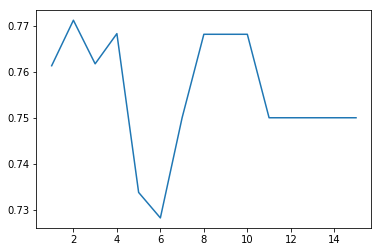

In [64]:
#KNN for different k values
kVals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(kVals,scores)    
print(scores)  

In [65]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
dsf = classification_report(y_test,pred)
print(dsf)
f1 = f1_score(y_test,pred,average='weighted') 
print('F1 Score: ',f1)
acc = accuracy_score(y_test,pred)
print('Accuracy is: ',acc)
cm = confusion_matrix(y_test,pred)

             precision    recall  f1-score   support

          0       0.50      0.06      0.11        16
          1       0.84      0.99      0.90        77

avg / total       0.78      0.83      0.77        93

F1 Score:  0.7682198327359617
Accuracy is:  0.8279569892473119


In [66]:
def plotConfusion(cm):
    sns.set_style('white')
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Developed','Developing']
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

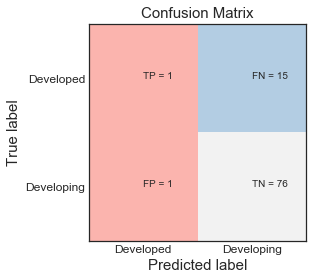

In [67]:
plotConfusion(cm)

#### Random Forest Classifier

In [68]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.7971923536439666
Accuracy Score:  0.8494623655913979


#### Fine tuninng Random Forest for different number of estimators

5-------0.8713134492048733
10-------0.7971923536439666
15-------0.7971923536439666
20-------0.7825625080969039
30-------0.8097421945847908
35-------0.7682198327359617
40-------0.7971923536439666
45-------0.7971923536439666
50-------0.7971923536439666
100-------0.7971923536439666
200-------0.7971923536439666
300-------0.7971923536439666


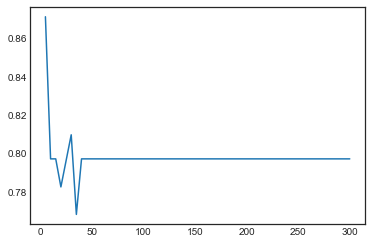

In [69]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
for i in range (0,len(estimators)):
    print(str(estimators[i]) + "-------" + str(f1_scores[i]))

#### Lets fine tune for number of features with best number of estimator from above analysis

In [70]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.8713134492048733
Accuracy Score:  0.8924731182795699


[0.8198388288868225, 0.7754224270353303, 0.8198388288868225, 0.7898091762146334, 0.7754224270353303, 0.7971923536439666, 0.7898091762146334, 0.7553828216090168, 0.7747100367155834, 0.7825625080969039, 0.7683642085687719]


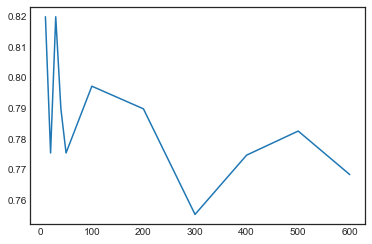

In [72]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=5,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
print(f1_scores)

In [74]:
rf_classifier = RandomForestClassifier(n_estimators=5, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
cr = classification_report(y_test,pred)
cm = confusion_matrix(y_test,pred)

F1 Score:  0.8713134492048733
Accuracy Score:  0.8924731182795699


             precision    recall  f1-score   support

          0       1.00      0.38      0.55        16
          1       0.89      1.00      0.94        77

avg / total       0.90      0.89      0.87        93



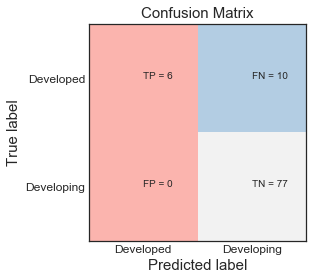

In [75]:
print(cr)
plotConfusion(cm)

#### Logistic regression model

In [77]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

F1 Score:  0.7877481389578163
Accuracy Score:  0.8064516129032258
             precision    recall  f1-score   support

          0       0.40      0.25      0.31        16
          1       0.86      0.92      0.89        77

avg / total       0.78      0.81      0.79        93



#### Extra tree classifier

In [78]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=5,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.7613671889564816
Accuracy Score:  0.7956989247311828


[0.7613671889564816, 0.8018433179723502, 0.8097421945847908, 0.8097421945847908, 0.7898091762146334, 0.7898091762146334, 0.7825625080969039, 0.7825625080969039, 0.7825625080969039, 0.7825625080969039, 0.7898091762146334, 0.7898091762146334]


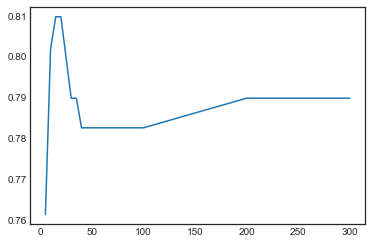

In [79]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
print(f1_scores)

In [91]:
model = ExtraTreesClassifier(n_estimators=20,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.7941015187277972
Accuracy Score:  0.8279569892473119


#### fine tune for max_features

[0.7747100367155834, 0.8018433179723502, 0.7825625080969039, 0.8178346193860156, 0.7825625080969039, 0.8280897384840037, 0.8097421945847908, 0.7941015187277972, 0.8198388288868225, 0.8097421945847908, 0.8018433179723502]


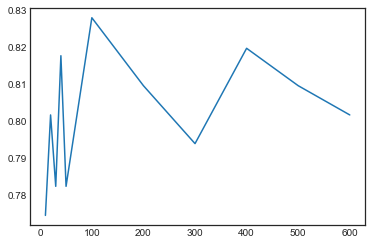

In [92]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=20,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
print(f1_scores)

In [95]:
20,500

#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=20,max_features=100,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
cr = classification_report(y_test,pred)
cm = confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))

F1 Score:  0.8280897384840037
Accuracy Score:  0.8494623655913979
             precision    recall  f1-score   support

          0       0.62      0.31      0.42        16
          1       0.87      0.96      0.91        77

avg / total       0.83      0.85      0.83        93



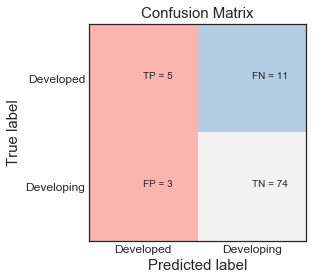

In [96]:
plotConfusion(cm)

#### Recursive Feature Elimination 

In [98]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 572
Best features : Index(['normalized__cid_ce__normalize_True', 'normalized__count_above_mean',
       'normalized__count_below_mean',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_2',
       'normalized__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_20',
       ...
       'normalized__symmetry_looking__r_0.9500000000000001',
       'normalized__time_reversal_asymmetry_statistic__lag_1',
       'normalized__time_reversal_asymmetry_statistic__lag_2',
       'normalized__time_reversal_asymmetry_statistic__lag_3',
       'normalized__value_count__va

In [99]:
cols = X_train.columns[rfecv.support_]

In [100]:
X = X[cols]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [102]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
dsf = classification_report(y_test,pred)
acc = accuracy_score(y_test,pred) 
print(dsf)
print('Accuracy is: ',acc)

             precision    recall  f1-score   support

          0       0.50      0.06      0.11        16
          1       0.84      0.99      0.90        77

avg / total       0.78      0.83      0.77        93

Accuracy is:  0.8279569892473119


[0.7956989247311828, 0.7526881720430108, 0.8172043010752689, 0.8172043010752689, 0.8064516129032258, 0.7849462365591398, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119, 0.8279569892473119]


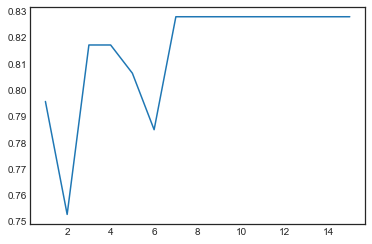

In [103]:
#KNN for different k values
kVals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test,pred))
    
plt.plot(kVals,scores)    
print(scores) 

[0.7682198327359617, 0.7747100367155834, 0.7500316255534472, 0.7446713749443278, 0.7446713749443278, 0.7500316255534472, 0.7500316255534472, 0.7500316255534472, 0.7500316255534472, 0.7747100367155834, 0.7747100367155834, 0.7747100367155834]


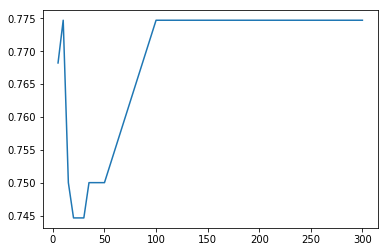

In [43]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
print(f1_scores)

In [107]:
rf_classifier = RandomForestClassifier(n_estimators=30, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
dsf = classification_report(y_test,pred)
acc = accuracy_score(y_test,pred) 
print(dsf)
print('Accuracy is: ',acc)
cm = confusion_matrix(y_test,pred)

             precision    recall  f1-score   support

          0       1.00      0.06      0.12        16
          1       0.84      1.00      0.91        77

avg / total       0.87      0.84      0.77        93

Accuracy is:  0.8387096774193549


In [108]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       1.00      0.06      0.12        16
          1       0.84      1.00      0.91        77

avg / total       0.87      0.84      0.77        93



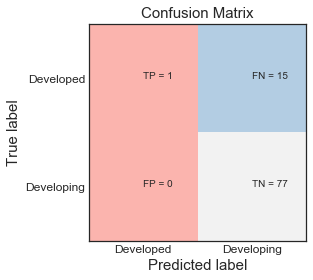

In [109]:
plotConfusion(cm)